In [1]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.io import SphericalTensor
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from models.electric_field_model.gate_points_networks_relaxed import SimpleNetwork,NetworkForAGraphWithAttributes
from models.electric_field_model.relaxed_points_conv import RelaxedConvolution
from torch_geometric.data import Data, DataLoader
from utils import train, plot_output, plot_weights, setup_geom, sim_E_B_field
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
import numpy as np
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
# Constants
q = 1.6e-19  # Charge of the particle (e.g., electron)
m = 9.1e-31  # Mass of the particle (e.g., electron)
dt = 0.1   # Time step for simulation
steps = 1000 # Number of simulation steps

In [49]:
trajectories, velocities, accels = sim_E_B_field(np.array([1.0,0.0,0.0]),np.array([0,1.0,0]),steps,dt,q,m)

Text(10, 15, 'B')

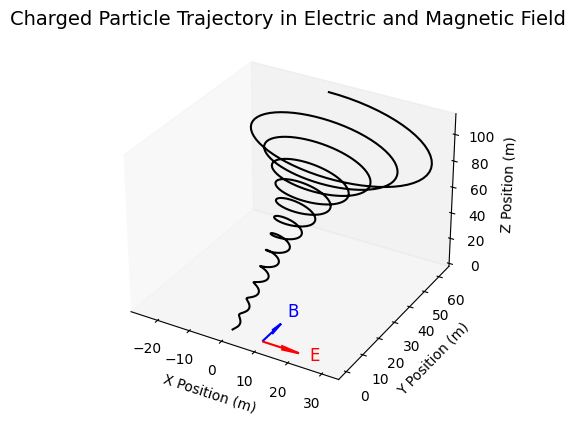

In [50]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectories
colors = ['r', 'b', 'green']
ind = 0
for particle_traj in trajectories[0:1]:
    ax.plot(particle_traj[:800, 0], particle_traj[:800, 1], particle_traj[:800, 2], color='black')
    ind += 1

# Set axis labels
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')

# Remove tick marks
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])

# Remove grid
ax.grid(False)

# Set the title
ax.set_title('Charged Particle Trajectory in Electric and Magnetic Field',fontsize=14)

# Add arrows for electric and magnetic fields to the side of the plot
# Electric field in the x direction
ax.quiver(10, 0, 0, 11, 0, 0, color='red', arrow_length_ratio=0.5)
ax.text(25, -2, 0, 'E', color='red', fontsize=12)

# Magnetic field in the y direction
ax.quiver(10, 0, 0, 0, 11, 0, color='blue', arrow_length_ratio=0.5)
ax.text(10, 15, 0, 'B', color='blue', fontsize=12)

In [51]:
trajectories = np.asarray(trajectories)
velocities = np.asarray(velocities)
accels = np.asarray(accels)

In [52]:
L_max = 5
irreps_input = o3.Irreps(None)
irreps_output = o3.Irreps("1x1o")
irreps_node_attr = o3.Irreps("1x0e+1x1o")

In [53]:
irreps_edge = o3.Irreps.spherical_harmonics(L_max)

In [54]:
model = NetworkForAGraphWithAttributes(irreps_input, irreps_node_attr, irreps_output,
max_radius = 1.8, num_neighbors = 4, num_nodes = 100,layers = 1,relaxed=True,pool_nodes=False).to(device)

In [55]:
optimizer = torch.optim.Adam(model.parameters(),5e-3)

In [56]:
model

NetworkForAGraphWithAttributes(
  (mp): MessagePassing(
    (layers): ModuleList(
      (0): Compose(
        (first): RelaxedConvolution(
          (sc): FullyConnectedTensorProduct(1x0e+1x0o+1x1o+1x1e+1x2e+1x2o x 1x0e+1x1o -> 50x0o+250x0e+50x1o+50x1e+50x2o+50x2e | 1300 paths | 1300 weights)
          (lin1): FullyConnectedTensorProduct(1x0e+1x0o+1x1o+1x1e+1x2e+1x2o x 1x0e+1x1o -> 1x0e+1x0o+1x1o+1x1e+1x2e+1x2o | 18 paths | 18 weights)
          (relaxed_edge_tp): FullyConnectedTensorProduct(1x0e+1x0o+1x1o+1x1e x 1x0e+1x1o+1x2e -> 1x0e+1x0o+1x1o+1x1e+1x2e+1x2o | 18 paths | 18 weights)
          (in_relaxed_tp): TensorProduct(1x0e+1x0o+1x1o+1x1e+1x2e+1x2o x 1x0e+1x0o+1x1o+1x1e+1x2e+1x2o -> 6x0o+6x0e+12x1o+12x1e+12x2o+12x2e | 60 paths | 60 weights)
          (fc_relaxed): FullyConnectedNet[1, 100, 60]
          (lin2): FullyConnectedTensorProduct(6x0o+6x0e+12x1o+12x1e+12x2o+12x2e x 1x0e+1x1o -> 50x0o+250x0e+50x1o+50x1e+50x2o+50x2e | 13200 paths | 13200 weights)
          (lin3): FullyCon

In [57]:
num_elems = 10
data_list = []
num = 500
for i in range(num):
    curr_data = Data(
    y = torch.DoubleTensor(accels[0,i,:]).reshape(1,3).to(device),
    node_attr = torch.cat((torch.ones(1, dtype=torch.float64), torch.DoubleTensor(velocities[0,i, :])), dim=0).reshape(1,4),
    pos = torch.DoubleTensor([0,0,0]).reshape(1,3)
    ).to(device)
    data_list.append(curr_data)

In [58]:
batch_size = 50
loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
def reg_norm_loss(relaxed_weights):
    return torch.norm(relaxed_weights[1])+torch.norm(relaxed_weights[2:5])+torch.norm(relaxed_weights[5:])

In [61]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.98)

In [62]:
criterion = torch.nn.MSELoss()
# Training loop
num_epochs = 1500
weight_decay = 1e-4
losses = []
best_loss = 1e10
for epoch in range(num_epochs):
    total_loss = 0
    for data in loader:
        # Forward pass
        output = model(data)
        regularization_loss = torch.tensor(0.0).to(device)
        for name, module in model.named_modules():  # Accessing the Sequential part
            if isinstance(module, RelaxedConvolution):
                regularization_loss += reg_norm_loss(module.relaxed_weights)
        regularization_loss *= weight_decay
        loss = criterion(output, data.y)
        loss += regularization_loss
        total_loss += loss.item()

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    # Print or log the relaxed weights
    if total_loss/len(data_list) < best_loss:
        best_model = model.state_dict()
    if epoch % 10 == 0:
        print("Epoch:", epoch)
        print(total_loss/len(data_list))
    losses.append(total_loss/len(data_list))
for name, param in model.named_parameters():
    if 'relaxed_weights' in name:
        print(name, param.data)

Epoch: 0
0.07433428446157356
Epoch: 10
0.07286473011011337
Epoch: 20
0.07143330441258965
Epoch: 30
0.070371915713236
Epoch: 40
0.06978362451452261
Epoch: 50
0.06944223522480174
Epoch: 60
0.0691374918301535
Epoch: 70
0.06879465229404576
Epoch: 80
0.06825917530994932
Epoch: 90
0.0667849385451797
Epoch: 100
0.059298845415281506
Epoch: 110
0.050148978541045386
Epoch: 120
0.039409279678554426
Epoch: 130
0.02924440565698823
Epoch: 140
0.016549698868456014
Epoch: 150
0.01114948879048603
Epoch: 160
0.009454298751839705
Epoch: 170
0.010706137289821747
Epoch: 180
0.007901341967350407
Epoch: 190
0.007559677887971011
Epoch: 200
0.006972967481477509
Epoch: 210
0.006639554785827063
Epoch: 220
0.0064765998964752824
Epoch: 230
0.006401344614981916
Epoch: 240
0.006116926329876037
Epoch: 250
0.00586126916691753
Epoch: 260
0.0056247076149177995
Epoch: 270
0.005386414103800525
Epoch: 280
0.0050832409010750515
Epoch: 290
0.004959906716323406
Epoch: 300
0.0046815555215970256
Epoch: 310
0.004559875147201942


KeyboardInterrupt: 

In [63]:
equiv_loss = losses

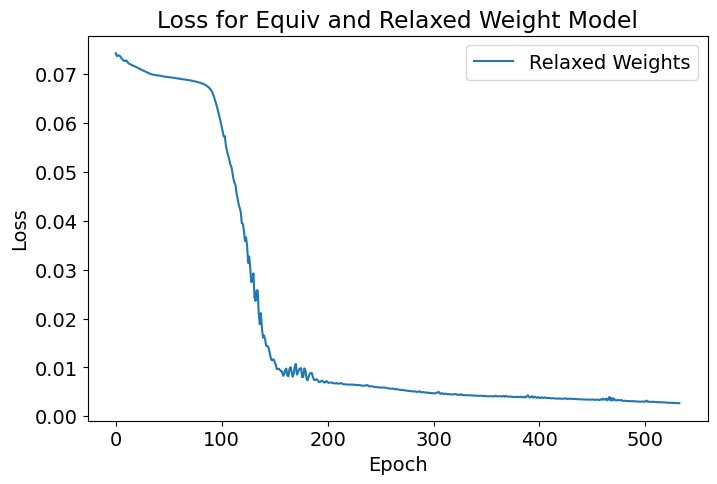

In [65]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.plot(equiv_loss, label = 'Relaxed Weights')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss for Equiv and Relaxed Weight Model')
plt.legend()
plt.savefig('losses.pdf')
#plt.yscale('log')
#plt.yscale('log')

In [66]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [67]:
for name, param in model.named_parameters():
    if 'relaxed_weights' in name:
        print(name, param.data)

mp.layers.0.first.relaxed_weights tensor([ 1.0436, -0.0688, -0.1574, -0.1746, -0.0540, -0.1504, -0.1287,  0.0877])
mp.layers.1.relaxed_weights tensor([ 1.0522e+00, -1.0861e-01,  1.0278e-01, -1.9186e-03, -4.5899e-03,
         8.8293e-04, -2.1986e-01, -1.3817e-02])


In [71]:
irreps_relaxed_iter =o3.Irrep.iterator(1)
irreps_relaxed = o3.Irreps("")
for irrep in irreps_relaxed_iter:
    irreps_relaxed += irrep

In [72]:
irreps_relaxed

1x0e+1x0o+1x1o+1x1e

In [74]:
# look at the relaxed weights of the last layer
relaxed_weights = best_model['mp.layers.1.relaxed_weights']

In [79]:
E_field_pred = relaxed_weights[2:5]
E_field_pred /= np.linalg.norm(E_field_pred)

In [80]:
E_field_pred

tensor([ 0.9988, -0.0186, -0.0446])

In [82]:
B_field_pred = relaxed_weights[5:]
B_field_pred /= np.linalg.norm(B_field_pred)

In [83]:
B_field_pred

tensor([ 0.0040, -0.9980, -0.0627])

In [85]:
import plotly.graph_objects as go
import numpy as np

v1 = E_field_pred
v2 = B_field_pred
v3 = np.array([1.0, 0, 0])  # x-axis
v4 = np.array([0, 1.0, 0])  # y-axis

# Define colors for the vectors
colors = ['black', 'gray', 'red', 'blue']#,'green','yellow']
dashes = ['dash', 'dash', 'solid', 'solid']  # Set dash styles
names = ['Predicted E field', 'Predicted B field', 'E field', 'B field']
opacities = [0.9,0.9,1.0,1.0]  # Set opacities
# Create line traces for each vector
lines = [
    go.Scatter3d(
        x=[0, v[0]],
        y=[0, v[1]],
        z=[0, v[2]],
        mode='lines',
        line=dict(color=c,width=12),
        opacity = o,
        name=n
    )
    for v, c, o, n in zip([v1,v2,v3,v4], colors, opacities, names)
]

# Create cone traces for each vector
cones = [
    go.Cone(
        x=[v[0]],
        y=[v[1]],
        z=[v[2]],
        u=[v[0]],
        v=[v[1]],
        w=[v[2]],
        anchor="tail",
        colorscale=[[0, c], [1, c]],
        showscale=False,
        opacity = o,
        name=n
    )
    for v, c, o, n in zip([v1,v2,v3,v4], colors, opacities, names)
]

# Combine lines and cones in the figure
fig = go.Figure(data=lines + cones)

# Set layout
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1.5, 1.5], title='X',showgrid = False,showbackground = False),
        yaxis=dict(range=[-1.5, 1.5], title='Y', showgrid = False,showbackground = False),
        zaxis=dict(range=[-1.5, 1.5], title='Z', showgrid = False, showbackground = False),
        aspectmode="cube"
    ),
    showlegend=True
)

# Show plot
fig.show()
fig.write_html('vectors.html')